# Introduction
***

Amazon SageMaker NTM (Neural Topic Model) is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. NTM is most commonly used to discover a user-specified number of topics shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified up front, and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics.

In this notebook we will use the Amazon SageMaker NTM algorithm to train a model on some example synthetic data. We will then use this model to classify (perform inference on) the data. The main goals of this notebook are to,

* create an AWS SageMaker training job on a data set to produce a NTM model,
* use the model to perform inference with an Amazon SageMaker endpoint.

In [1]:
import os
import sagemaker
import boto3
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

role = get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-228889150161


## Training

Once the data is preprocessed and available in a recommended format the next step is to train our model on the data. There are number of parameters required by the NTM algorithm to configure the model and define the computational environment in which training will take place. The first of these is to point to a container image which holds the algorithms training and hosting code.

In [2]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/ntm:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/ntm:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/ntm:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/ntm:latest'}

An NTM model uses the following hyperparameters:

- **num_topics** - The number of topics or categories in the NTM model. 
- **feature_dim** - The size of the "vocabulary". In this case, this has been set to 1000 by the nytimes pyspark data prep.

In addition to these NTM model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role.

> Note: Try adjusting the mini_batch_size if running on a GPU. 

In [3]:
num_topics=20
vocabulary_size=5000
output = 's3://{}/data/nytimes-model/sagemaker-ntm'.format(sagemaker_session.default_bucket())

ntm = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p3.2xlarge',
                                    output_path=output,
                                    sagemaker_session=sagemaker_session)

ntm.set_hyperparameters(num_topics=num_topics,
                        feature_dim=vocabulary_size,
                        mini_batch_size=1024,
                        epochs=100)

We'll train against the bag-of-words extracted from the NY Times comments.

In [4]:
import boto3
s3_client = boto3.client('s3')
objects = s3_client.list_objects(Bucket=bucket, Prefix='data/nyt-record-io/training.rec')
training_key = objects['Contents'][0]['Key']
training_input = 's3://{}/{}'.format(bucket, training_key)

In [5]:
ntm.fit({'train': training_input})

INFO:sagemaker:Creating training-job with name: ntm-2018-06-03-17-41-29-942


.........................
Docker entrypoint called with argument(s): train
[06/03/2018 17:45:23 INFO 140233695053632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'tolerance': u'0.001', u'batch_norm': u'false'}
[06/03/2018 17:45:23 INFO 140233695053632] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'epochs': u'100', u'feature_dim': u'5000', u'mini_batch_size': u'1024', u'num_topics': u'20'}
[06/03/2018 17:45:23 INFO 140233695053632] Final configuration: {u'num_patience_epochs': u'3'

[06/03/2018 17:45:57 INFO 140233695053632] # Finished training epoch 5 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:45:57 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:45:57 INFO 140233695053632] Loss (name: value) total: 7.67566204317
[06/03/2018 17:45:57 INFO 140233695053632] Loss (name: value) kld: 0.0193515777624
[06/03/2018 17:45:57 INFO 140233695053632] Loss (name: value) recons: 7.65631049256
[06/03/2018 17:45:57 INFO 140233695053632] Loss (name: value) logppx: 7.67566204317
[06/03/2018 17:45:57 INFO 140233695053632] #quality_metric: host=algo-1, epoch=5, train total_loss <loss>=7.67566204317
[06/03/2018 17:45:57 INFO 140233695053632] patience losses:[7.700584696097807, 7.6894773175893736, 7.6823241252544499] min patience loss:7.68232412525 current loss:7.67566204317 absolute loss difference:0.006662082081
[06/03/2018 17:45:57 INFO 140233695053632] #progress_metric: host=algo-1, completed 5 % of epochs
#metrics {"Metrics": {"Max Batches See

[06/03/2018 17:46:16 INFO 140233695053632] # Finished training epoch 9 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:46:16 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:46:16 INFO 140233695053632] Loss (name: value) total: 7.66294347797
[06/03/2018 17:46:16 INFO 140233695053632] Loss (name: value) kld: 0.0235288414646
[06/03/2018 17:46:16 INFO 140233695053632] Loss (name: value) recons: 7.63941462523
[06/03/2018 17:46:16 INFO 140233695053632] Loss (name: value) logppx: 7.66294347797
[06/03/2018 17:46:16 INFO 140233695053632] #quality_metric: host=algo-1, epoch=9, train total_loss <loss>=7.66294347797
[06/03/2018 17:46:16 INFO 140233695053632] patience losses:[7.6728276329592235, 7.6688663466902804, 7.6654402012667378] min patience loss:7.66544020127 current loss:7.66294347797 absolute loss difference:0.00249672330115
[06/03/2018 17:46:16 INFO 140233695053632] #progress_metric: host=algo-1, completed 9 % of epochs
#metrics {"Metrics": {"Max Batches 

[06/03/2018 17:46:40 INFO 140233695053632] # Finished training epoch 14 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:46:40 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:46:40 INFO 140233695053632] Loss (name: value) total: 7.6516125813
[06/03/2018 17:46:40 INFO 140233695053632] Loss (name: value) kld: 0.0276173064043
[06/03/2018 17:46:40 INFO 140233695053632] Loss (name: value) recons: 7.62399528711
[06/03/2018 17:46:40 INFO 140233695053632] Loss (name: value) logppx: 7.6516125813
[06/03/2018 17:46:40 INFO 140233695053632] #quality_metric: host=algo-1, epoch=14, train total_loss <loss>=7.6516125813
[06/03/2018 17:46:40 INFO 140233695053632] patience losses:[7.6578247507741626, 7.6557241550161823, 7.6541426674393582] min patience loss:7.65414266744 current loss:7.6516125813 absolute loss difference:0.00253008613902
[06/03/2018 17:46:40 INFO 140233695053632] #progress_metric: host=algo-1, completed 14 % of epochs
#metrics {"Metrics": {"Max Batches S

[06/03/2018 17:47:09 INFO 140233695053632] # Finished training epoch 20 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:47:09 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:47:09 INFO 140233695053632] Loss (name: value) total: 7.62053587589
[06/03/2018 17:47:09 INFO 140233695053632] Loss (name: value) kld: 0.0564985080384
[06/03/2018 17:47:09 INFO 140233695053632] Loss (name: value) recons: 7.56403734615
[06/03/2018 17:47:09 INFO 140233695053632] Loss (name: value) logppx: 7.62053587589
[06/03/2018 17:47:09 INFO 140233695053632] #quality_metric: host=algo-1, epoch=20, train total_loss <loss>=7.62053587589
[06/03/2018 17:47:09 INFO 140233695053632] patience losses:[7.6334238224778295, 7.6272587810666108, 7.6232519435488486] min patience loss:7.62325194355 current loss:7.62053587589 absolute loss difference:0.00271606765503
[06/03/2018 17:47:09 INFO 140233695053632] #progress_metric: host=algo-1, completed 20 % of epochs
#metrics {"Metrics": {"Max Batch

[06/03/2018 17:47:28 INFO 140233695053632] # Finished training epoch 24 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:47:28 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:47:28 INFO 140233695053632] Loss (name: value) total: 7.60112801761
[06/03/2018 17:47:28 INFO 140233695053632] Loss (name: value) kld: 0.0724000387425
[06/03/2018 17:47:28 INFO 140233695053632] Loss (name: value) recons: 7.52872796566
[06/03/2018 17:47:28 INFO 140233695053632] Loss (name: value) logppx: 7.60112801761
[06/03/2018 17:47:28 INFO 140233695053632] #quality_metric: host=algo-1, epoch=24, train total_loss <loss>=7.60112801761
[06/03/2018 17:47:28 INFO 140233695053632] patience losses:[7.6163235232849749, 7.6129691521983505, 7.6073799308173911] min patience loss:7.60737993082 current loss:7.60112801761 absolute loss difference:0.00625191321058
[06/03/2018 17:47:28 INFO 140233695053632] #progress_metric: host=algo-1, completed 24 % of epochs
#metrics {"Metrics": {"Max Batch

[06/03/2018 17:47:48 INFO 140233695053632] # Finished training epoch 28 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:47:48 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:47:48 INFO 140233695053632] Loss (name: value) total: 7.58106571387
[06/03/2018 17:47:48 INFO 140233695053632] Loss (name: value) kld: 0.0874590917783
[06/03/2018 17:47:48 INFO 140233695053632] Loss (name: value) recons: 7.49360664965
[06/03/2018 17:47:48 INFO 140233695053632] Loss (name: value) logppx: 7.58106571387
[06/03/2018 17:47:48 INFO 140233695053632] #quality_metric: host=algo-1, epoch=28, train total_loss <loss>=7.58106571387
[06/03/2018 17:47:48 INFO 140233695053632] patience losses:[7.5945136697331739, 7.5889624108460323, 7.5849436028929782] min patience loss:7.58494360289 current loss:7.58106571387 absolute loss difference:0.0038778890263
[06/03/2018 17:47:48 INFO 140233695053632] #progress_metric: host=algo-1, completed 28 % of epochs
#metrics {"Metrics": {"Max Batche

[06/03/2018 17:48:07 INFO 140233695053632] # Finished training epoch 32 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:48:07 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:48:07 INFO 140233695053632] Loss (name: value) total: 7.56802198315
[06/03/2018 17:48:07 INFO 140233695053632] Loss (name: value) kld: 0.100351464196
[06/03/2018 17:48:07 INFO 140233695053632] Loss (name: value) recons: 7.46767053796
[06/03/2018 17:48:07 INFO 140233695053632] Loss (name: value) logppx: 7.56802198315
[06/03/2018 17:48:07 INFO 140233695053632] #quality_metric: host=algo-1, epoch=32, train total_loss <loss>=7.56802198315
[06/03/2018 17:48:07 INFO 140233695053632] patience losses:[7.5785896223931273, 7.5749946773544812, 7.5722230160531918] min patience loss:7.57222301605 current loss:7.56802198315 absolute loss difference:0.00420103289864
[06/03/2018 17:48:07 INFO 140233695053632] #progress_metric: host=algo-1, completed 32 % of epochs
#metrics {"Metrics": {"Max Batche

[06/03/2018 17:48:31 INFO 140233695053632] # Finished training epoch 37 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:48:31 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:48:31 INFO 140233695053632] Loss (name: value) total: 7.55857551098
[06/03/2018 17:48:31 INFO 140233695053632] Loss (name: value) kld: 0.110370726063
[06/03/2018 17:48:31 INFO 140233695053632] Loss (name: value) recons: 7.44820480825
[06/03/2018 17:48:31 INFO 140233695053632] Loss (name: value) logppx: 7.55857551098
[06/03/2018 17:48:31 INFO 140233695053632] #quality_metric: host=algo-1, epoch=37, train total_loss <loss>=7.55857551098
[06/03/2018 17:48:31 INFO 140233695053632] patience losses:[7.5633487216204651, 7.5608535918815081, 7.5597764554102556] min patience loss:7.55977645541 current loss:7.55857551098 absolute loss difference:0.00120094443156
[06/03/2018 17:48:31 INFO 140233695053632] #progress_metric: host=algo-1, completed 37 % of epochs
#metrics {"Metrics": {"Max Batche

[06/03/2018 17:48:50 INFO 140233695053632] # Finished training epoch 41 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:48:50 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:48:50 INFO 140233695053632] Loss (name: value) total: 7.55371197516
[06/03/2018 17:48:50 INFO 140233695053632] Loss (name: value) kld: 0.114320332208
[06/03/2018 17:48:50 INFO 140233695053632] Loss (name: value) recons: 7.43939164724
[06/03/2018 17:48:50 INFO 140233695053632] Loss (name: value) logppx: 7.55371197516
[06/03/2018 17:48:50 INFO 140233695053632] #quality_metric: host=algo-1, epoch=41, train total_loss <loss>=7.55371197516
[06/03/2018 17:48:50 INFO 140233695053632] patience losses:[7.5565956318674008, 7.5556589596527663, 7.5550886752191655] min patience loss:7.55508867522 current loss:7.55371197516 absolute loss difference:0.00137670005649
[06/03/2018 17:48:50 INFO 140233695053632] #progress_metric: host=algo-1, completed 41 % of epochs
#metrics {"Metrics": {"Max Batche

[06/03/2018 17:49:09 INFO 140233695053632] # Finished training epoch 45 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:49:09 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:49:09 INFO 140233695053632] Loss (name: value) total: 7.55124838933
[06/03/2018 17:49:09 INFO 140233695053632] Loss (name: value) kld: 0.117382870117
[06/03/2018 17:49:09 INFO 140233695053632] Loss (name: value) recons: 7.43386553142
[06/03/2018 17:49:09 INFO 140233695053632] Loss (name: value) logppx: 7.55124838933
[06/03/2018 17:49:09 INFO 140233695053632] #quality_metric: host=algo-1, epoch=45, train total_loss <loss>=7.55124838933
[06/03/2018 17:49:09 INFO 140233695053632] patience losses:[7.5532537127329302, 7.5531142041210302, 7.5517515567216007] min patience loss:7.55175155672 current loss:7.55124838933 absolute loss difference:0.000503167386882
[06/03/2018 17:49:09 INFO 140233695053632] Bad epoch: loss has not improved (enough). Bad count:1
[06/03/2018 17:49:09 INFO 1402336

[06/03/2018 17:49:29 INFO 140233695053632] # Finished training epoch 49 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:49:29 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:49:29 INFO 140233695053632] Loss (name: value) total: 7.54704588233
[06/03/2018 17:49:29 INFO 140233695053632] Loss (name: value) kld: 0.122145494954
[06/03/2018 17:49:29 INFO 140233695053632] Loss (name: value) recons: 7.42490036773
[06/03/2018 17:49:29 INFO 140233695053632] Loss (name: value) logppx: 7.54704588233
[06/03/2018 17:49:29 INFO 140233695053632] #quality_metric: host=algo-1, epoch=49, train total_loss <loss>=7.54704588233
[06/03/2018 17:49:29 INFO 140233695053632] patience losses:[7.5505730593500058, 7.5500576570014326, 7.5481454156154442] min patience loss:7.54814541562 current loss:7.54704588233 absolute loss difference:0.00109953328598
[06/03/2018 17:49:29 INFO 140233695053632] #progress_metric: host=algo-1, completed 49 % of epochs
#metrics {"Metrics": {"Max Batche

[06/03/2018 17:49:53 INFO 140233695053632] # Finished training epoch 54 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:49:53 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:49:53 INFO 140233695053632] Loss (name: value) total: 7.53473522372
[06/03/2018 17:49:53 INFO 140233695053632] Loss (name: value) kld: 0.136606155148
[06/03/2018 17:49:53 INFO 140233695053632] Loss (name: value) recons: 7.39812909448
[06/03/2018 17:49:53 INFO 140233695053632] Loss (name: value) logppx: 7.53473522372
[06/03/2018 17:49:53 INFO 140233695053632] #quality_metric: host=algo-1, epoch=54, train total_loss <loss>=7.53473522372
[06/03/2018 17:49:53 INFO 140233695053632] patience losses:[7.5418646702589083, 7.539416742226309, 7.5364042407224989] min patience loss:7.53640424072 current loss:7.53473522372 absolute loss difference:0.00166901699768
[06/03/2018 17:49:53 INFO 140233695053632] #progress_metric: host=algo-1, completed 54 % of epochs
#metrics {"Metrics": {"Max Batches

[06/03/2018 17:50:12 INFO 140233695053632] # Finished training epoch 58 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:50:12 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:50:12 INFO 140233695053632] Loss (name: value) total: 7.52279077606
[06/03/2018 17:50:12 INFO 140233695053632] Loss (name: value) kld: 0.147579937011
[06/03/2018 17:50:12 INFO 140233695053632] Loss (name: value) recons: 7.37521086818
[06/03/2018 17:50:12 INFO 140233695053632] Loss (name: value) logppx: 7.52279077606
[06/03/2018 17:50:12 INFO 140233695053632] #quality_metric: host=algo-1, epoch=58, train total_loss <loss>=7.52279077606
[06/03/2018 17:50:12 INFO 140233695053632] patience losses:[7.5322522390479882, 7.5286632295975018, 7.526651865440952] min patience loss:7.52665186544 current loss:7.52279077606 absolute loss difference:0.00386108938328
[06/03/2018 17:50:12 INFO 140233695053632] #progress_metric: host=algo-1, completed 58 % of epochs
#metrics {"Metrics": {"Max Batches

[06/03/2018 17:50:35 INFO 140233695053632] # Finished training epoch 63 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:50:35 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:50:35 INFO 140233695053632] Loss (name: value) total: 7.51086177609
[06/03/2018 17:50:35 INFO 140233695053632] Loss (name: value) kld: 0.161290342704
[06/03/2018 17:50:35 INFO 140233695053632] Loss (name: value) recons: 7.34957142581
[06/03/2018 17:50:35 INFO 140233695053632] Loss (name: value) logppx: 7.51086177609
[06/03/2018 17:50:35 INFO 140233695053632] #quality_metric: host=algo-1, epoch=63, train total_loss <loss>=7.51086177609
[06/03/2018 17:50:35 INFO 140233695053632] patience losses:[7.5171343866458606, 7.5148123202245101, 7.5118297269521666] min patience loss:7.51182972695 current loss:7.51086177609 absolute loss difference:0.000967950860331
[06/03/2018 17:50:35 INFO 140233695053632] Bad epoch: loss has not improved (enough). Bad count:1
[06/03/2018 17:50:35 INFO 1402336

[06/03/2018 17:50:54 INFO 140233695053632] # Finished training epoch 67 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:50:54 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:50:54 INFO 140233695053632] Loss (name: value) total: 7.50623418674
[06/03/2018 17:50:54 INFO 140233695053632] Loss (name: value) kld: 0.166426347422
[06/03/2018 17:50:54 INFO 140233695053632] Loss (name: value) recons: 7.33980783796
[06/03/2018 17:50:54 INFO 140233695053632] Loss (name: value) logppx: 7.50623418674
[06/03/2018 17:50:54 INFO 140233695053632] #quality_metric: host=algo-1, epoch=67, train total_loss <loss>=7.50623418674
[06/03/2018 17:50:54 INFO 140233695053632] patience losses:[7.5096401187999193, 7.5078918850126346, 7.5067520407605759] min patience loss:7.50675204076 current loss:7.50623418674 absolute loss difference:0.000517854020615
[06/03/2018 17:50:54 INFO 140233695053632] Bad epoch: loss has not improved (enough). Bad count:1
[06/03/2018 17:50:54 INFO 1402336

[06/03/2018 17:51:14 INFO 140233695053632] # Finished training epoch 71 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:51:14 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:51:14 INFO 140233695053632] Loss (name: value) total: 7.5025609409
[06/03/2018 17:51:14 INFO 140233695053632] Loss (name: value) kld: 0.169857937165
[06/03/2018 17:51:14 INFO 140233695053632] Loss (name: value) recons: 7.33270301282
[06/03/2018 17:51:14 INFO 140233695053632] Loss (name: value) logppx: 7.5025609409
[06/03/2018 17:51:14 INFO 140233695053632] #quality_metric: host=algo-1, epoch=71, train total_loss <loss>=7.5025609409
[06/03/2018 17:51:14 INFO 140233695053632] patience losses:[7.5056832363782835, 7.5045408530176179, 7.503982136811107] min patience loss:7.50398213681 current loss:7.5025609409 absolute loss difference:0.00142119590901
[06/03/2018 17:51:14 INFO 140233695053632] #progress_metric: host=algo-1, completed 71 % of epochs
#metrics {"Metrics": {"Max Batches See

[06/03/2018 17:51:33 INFO 140233695053632] # Finished training epoch 75 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:51:33 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:51:33 INFO 140233695053632] Loss (name: value) total: 7.50088249652
[06/03/2018 17:51:33 INFO 140233695053632] Loss (name: value) kld: 0.174357744927
[06/03/2018 17:51:33 INFO 140233695053632] Loss (name: value) recons: 7.32652478105
[06/03/2018 17:51:33 INFO 140233695053632] Loss (name: value) logppx: 7.50088249652
[06/03/2018 17:51:33 INFO 140233695053632] #quality_metric: host=algo-1, epoch=75, train total_loss <loss>=7.50088249652
[06/03/2018 17:51:33 INFO 140233695053632] patience losses:[7.5034035784153899, 7.5022400595432472, 7.5010522764083767] min patience loss:7.50105227641 current loss:7.50088249652 absolute loss difference:0.000169779889839
[06/03/2018 17:51:33 INFO 140233695053632] Bad epoch: loss has not improved (enough). Bad count:1
[06/03/2018 17:51:33 INFO 1402336

[06/03/2018 17:51:52 INFO 140233695053632] # Finished training epoch 79 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:51:52 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:51:52 INFO 140233695053632] Loss (name: value) total: 7.49373317947
[06/03/2018 17:51:52 INFO 140233695053632] Loss (name: value) kld: 0.181567505356
[06/03/2018 17:51:52 INFO 140233695053632] Loss (name: value) recons: 7.31216571843
[06/03/2018 17:51:52 INFO 140233695053632] Loss (name: value) logppx: 7.49373317947
[06/03/2018 17:51:52 INFO 140233695053632] #quality_metric: host=algo-1, epoch=79, train total_loss <loss>=7.49373317947
[06/03/2018 17:51:52 INFO 140233695053632] patience losses:[7.499789870228649, 7.4971635592870474, 7.4963496349567222] min patience loss:7.49634963496 current loss:7.49373317947 absolute loss difference:0.002616455486
[06/03/2018 17:51:52 INFO 140233695053632] #progress_metric: host=algo-1, completed 79 % of epochs
#metrics {"Metrics": {"Max Batches S

[06/03/2018 17:52:15 INFO 140233695053632] # Finished training epoch 84 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:52:15 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:52:15 INFO 140233695053632] Loss (name: value) total: 7.48805518362
[06/03/2018 17:52:15 INFO 140233695053632] Loss (name: value) kld: 0.189977343325
[06/03/2018 17:52:15 INFO 140233695053632] Loss (name: value) recons: 7.29807785055
[06/03/2018 17:52:15 INFO 140233695053632] Loss (name: value) logppx: 7.48805518362
[06/03/2018 17:52:15 INFO 140233695053632] #quality_metric: host=algo-1, epoch=84, train total_loss <loss>=7.48805518362
[06/03/2018 17:52:15 INFO 140233695053632] patience losses:[7.4901144568585165, 7.489398249417297, 7.4881498454030879] min patience loss:7.4881498454 current loss:7.48805518362 absolute loss difference:9.46617816107e-05
[06/03/2018 17:52:15 INFO 140233695053632] Bad epoch: loss has not improved (enough). Bad count:1
[06/03/2018 17:52:15 INFO 140233695

[06/03/2018 17:52:35 INFO 140233695053632] # Finished training epoch 88 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:52:35 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:52:35 INFO 140233695053632] Loss (name: value) total: 7.48353875275
[06/03/2018 17:52:35 INFO 140233695053632] Loss (name: value) kld: 0.193893021496
[06/03/2018 17:52:35 INFO 140233695053632] Loss (name: value) recons: 7.28964573958
[06/03/2018 17:52:35 INFO 140233695053632] Loss (name: value) logppx: 7.48353875275
[06/03/2018 17:52:35 INFO 140233695053632] #quality_metric: host=algo-1, epoch=88, train total_loss <loss>=7.48353875275
[06/03/2018 17:52:35 INFO 140233695053632] patience losses:[7.4857280604110272, 7.4847950807287678, 7.4851125072349198] min patience loss:7.48479508073 current loss:7.48353875275 absolute loss difference:0.00125632798376
[06/03/2018 17:52:35 INFO 140233695053632] #progress_metric: host=algo-1, completed 88 % of epochs
#metrics {"Metrics": {"Max Batche

[06/03/2018 17:52:55 INFO 140233695053632] # Finished training epoch 92 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:52:55 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:52:55 INFO 140233695053632] Loss (name: value) total: 7.4800102329
[06/03/2018 17:52:55 INFO 140233695053632] Loss (name: value) kld: 0.197619647911
[06/03/2018 17:52:55 INFO 140233695053632] Loss (name: value) recons: 7.28239061468
[06/03/2018 17:52:55 INFO 140233695053632] Loss (name: value) logppx: 7.4800102329
[06/03/2018 17:52:55 INFO 140233695053632] #quality_metric: host=algo-1, epoch=92, train total_loss <loss>=7.4800102329
[06/03/2018 17:52:55 INFO 140233695053632] patience losses:[7.4823033354006521, 7.4821807025385301, 7.4817777441060249] min patience loss:7.48177774411 current loss:7.4800102329 absolute loss difference:0.00176751121017
[06/03/2018 17:52:55 INFO 140233695053632] #progress_metric: host=algo-1, completed 92 % of epochs
#metrics {"Metrics": {"Max Batches Se

[06/03/2018 17:53:15 INFO 140233695053632] # Finished training epoch 96 on 246918 examples from 242 batches, each of size 1024.
[06/03/2018 17:53:15 INFO 140233695053632] Metrics for Training:
[06/03/2018 17:53:15 INFO 140233695053632] Loss (name: value) total: 7.47876686572
[06/03/2018 17:53:15 INFO 140233695053632] Loss (name: value) kld: 0.199934574798
[06/03/2018 17:53:15 INFO 140233695053632] Loss (name: value) recons: 7.27883229226
[06/03/2018 17:53:15 INFO 140233695053632] Loss (name: value) logppx: 7.47876686572
[06/03/2018 17:53:15 INFO 140233695053632] #quality_metric: host=algo-1, epoch=96, train total_loss <loss>=7.47876686572
[06/03/2018 17:53:15 INFO 140233695053632] patience losses:[7.4800819567412384, 7.479575819959325, 7.4797183989493314] min patience loss:7.47957581996 current loss:7.47876686572 absolute loss difference:0.000808954238892
[06/03/2018 17:53:15 INFO 140233695053632] Bad epoch: loss has not improved (enough). Bad count:4
[06/03/2018 17:53:15 INFO 14023369

## Inference

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document or comment.

This is simplified by the deploy function provided by the Amazon SageMaker Python SDK.

In [12]:
ntm_predictor = ntm.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge',
                          endpoint_name='ntm-nyt')

INFO:sagemaker:Creating model with name: ntm-2018-06-03-18-47-33-649
INFO:sagemaker:Creating endpoint with name ntm-nyt


---------------------------------------------------------------!

## Model Exploration 

This next section is based on ["An Introduction to SageMaker Neural Topic Model"](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/ntm_20newsgroups_topic_modeling/ntm_20newsgroups_topic_model.ipynb).  While this section is not required for model deployment, it does offer some explaination of the topic. 

In [6]:
!pip install mxnet 
import mxnet as mx

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
model_path = os.path.join('data/nytimes-model/sagemaker-ntm', ntm._current_job_name, 'output/model.tar.gz')
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')
!tar -xzvf 'downloaded_model.tar.gz'
!unzip -o model_algo-1

model_algo-1
Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [8]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

In [9]:
!pip install wordcloud
import wordcloud as wc

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import boto3
import json

s3 = boto3.resource('s3')
obj = s3.Object('sagemaker-us-east-1-228889150161','data/nyt-features/vocab.json')
obj.download_file('vocab.json')

def load_vocab():
    with open('vocab.json', 'r') as json_file:
        return json.load(json_file)

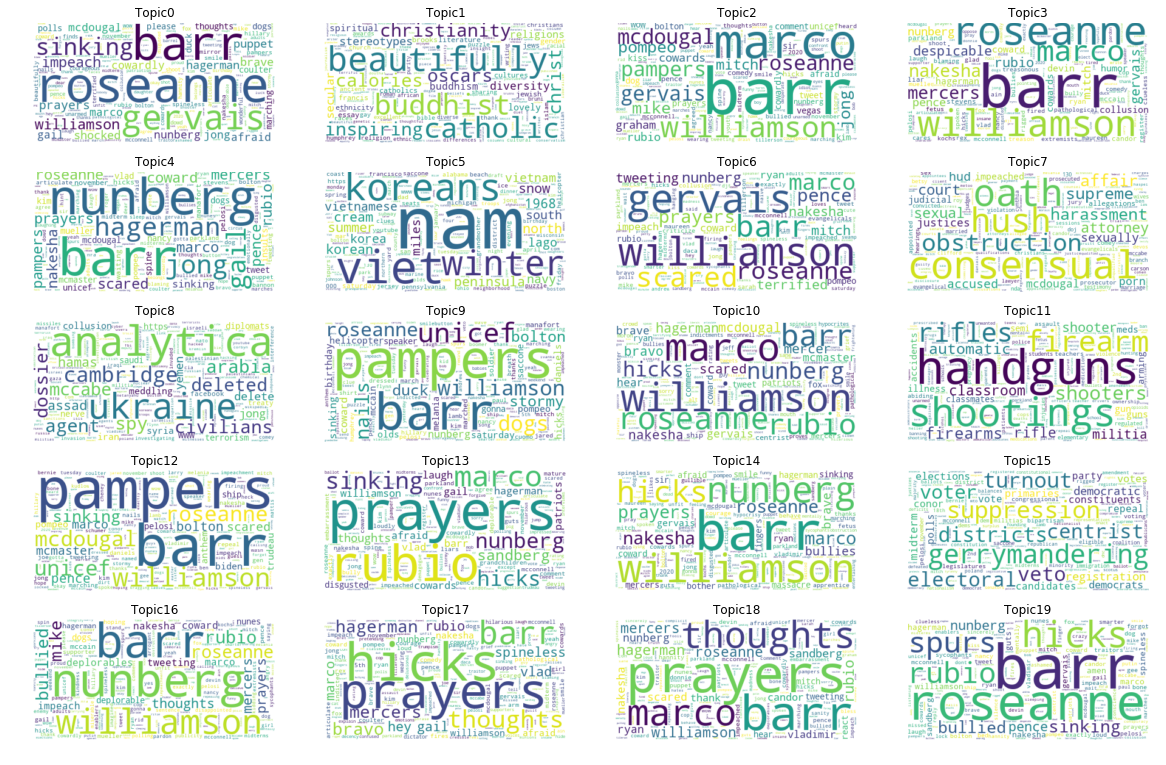

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

word_to_id = load_vocab()

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1
